# ADL Model Tests

Summary : 
ADL trained using RELU activations obviously clips  the lower bound to zero , producing zero response to negative signal. This can be seen from range of denoised results being [0,1]. Plots also show the same. 
Hence, all 'denoiser' related activations having role in producing the denoised output need to be changed to 'Tanh'. 

The following results show that replacing the RELU & SIGMOID with tanh activation improves the denoised image significantly. Error reduces from 0.3 to 0.05 
Moreover, removing batch normalisation reduces the train loss marginally, but reduces val losses significantly. 0.12 to 0.04

In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install -qq rich pytorch-lightning==1.7.7 scikit-image==0.19.2
# !git clone https://github.com/jayantb1019/adl_seismic.git
# !mkdir -p /content/adl_seismic/data
# !unzip /content/drive/MyDrive/faciesmark.zip -d /content/adl_seismic/data/.
# !cp /content/drive/MyDrive/denoiser_20230213_epoch=49-step=27600.ckpt /content/denoiser_20230213_epoch=49-step=27600.ckpt
# !cp /content/drive/MyDrive/discriminator_20230213_epoch=49-step=27600.ckpt /content/discriminator_20230213_epoch=49-step=27600.ckpt

In [37]:
import numpy as np 
import pytorch_lightning as pl 
import torch 
import yaml

import matplotlib.pyplot as plt

import sys 
sys.path.append("../models")
sys.path.append("../utils")
sys.path.append("../noise")
sys.path.append("../lightning_logs")
sys.path.append("../data")

# sys.path.append(r"..\models")
# sys.path.append(r"..\utils")
# sys.path.append(r"..\lightning_logs")
# sys.path.append(r"..\data")


from adl import Efficient_U, ADL, Efficient_U_DISC
from random_noise import add_noise

In [38]:


CONFIG_PATH= '../config/config_adl_faciesmark.yaml'
test_data_path = '../data/faciesmark/test_once/test2_seismic.npy'
denoiser_ckpt_path = '/local1/workspace/adl_seismic/lightning_logs/denoiser/adl_20_02_2023_12_50_02/checkpoints/epoch=49-step=2750.ckpt'
discriminator_ckpt_path = '/local1/workspace/adl_seismic/lightning_logs/discriminator/adl_20_02_2023_18_04_26/checkpoints/epoch=99-step=54600.ckpt'
adl_ckpt_path = '/local1/workspace/adl_seismic/lightning_logs/adl/adl_20_02_2023_18_04_26/checkpoints/epoch=50-step=55692.ckpt'


# CONFIG_PATH = r'Z:\experiments_feb\config\config_adl_faciesmark.yaml'
# test_data_path = r'Z:\experiments_feb\data\faciesmark\test_once\test2_seismic.npy'
# ckpt_path = r'Z:\experiments_feb\lightning_logs\denoiser_20230213_epoch=49-step=27600.ckpt'

def get_config(config_path) : 
    # read config file 
    with open(config_path, 'r') as f : 
        config = yaml.safe_load(f)
    f.close()
    return config

config = get_config(CONFIG_PATH)


In [39]:
test_data = np.load(test_data_path)
noisy_test_data = add_noise(test_data, mode='gaussian', mean=0,noise_factor=0.01)
model = Efficient_U.load_from_checkpoint(checkpoint_path=denoiser_ckpt_path, config=config)

discriminator = Efficient_U_DISC.load_from_checkpoint(model = model, config=config, checkpoint_path=discriminator_ckpt_path)

model_gan = ADL.load_from_checkpoint(checkpoint_path=adl_ckpt_path, config=config , denoiser = model, discriminator = discriminator , strict=False)


In [40]:
random_iline_no = np.random.randint(600)
random_iline_no

147

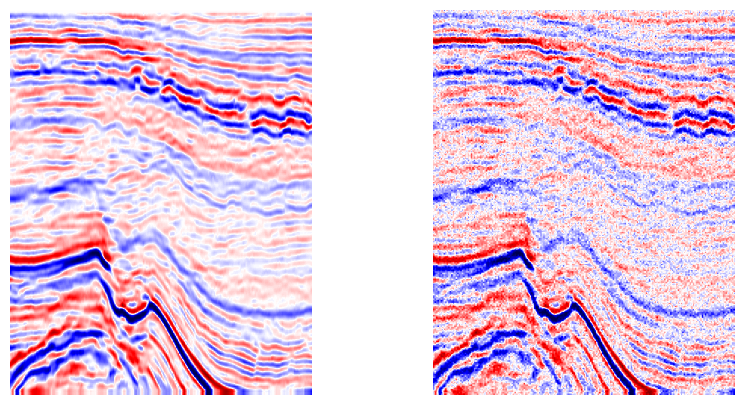

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(5*2, 5))

clean_inline = test_data[random_iline_no]
noisy_inline = noisy_test_data[random_iline_no]

kwargs = dict(cmap = 'seismic', vmin = -1, vmax = 1)

ax[0].imshow(clean_inline.T, **kwargs)
ax[0].axis('off')
ax[1].imshow(noisy_inline.T, **kwargs)
ax[1].axis('off')
plt.show()

In [42]:
# padded input 
test_pd = np.zeros((noisy_test_data.shape[0],noisy_test_data.shape[1],noisy_test_data.shape[2] + 1 ))
display(test_pd.shape)

test_pd[:,:,:noisy_test_data.shape[2]] = noisy_test_data

test_pd = test_pd.transpose(0,2,1)

(601, 200, 256)

In [43]:
device = 'cuda'
torch.cuda.empty_cache()
import gc 
gc.collect()
noisy_test_tensor = torch.from_numpy(np.expand_dims(test_pd, axis=1)).float().to(device)
model = model.to(device)
model.eval()

with torch.no_grad() : 
    denoised , _ , _ = model(noisy_test_tensor[:10])

In [44]:
device = 'cuda'
torch.cuda.empty_cache()
import gc 
gc.collect()
noisy_test_tensor = torch.from_numpy(np.expand_dims(test_pd, axis=1)).float().to(device)
model_gan = model_gan.to(device)
model_gan.eval()

with torch.no_grad() : 
    denoised_gan , _ , _ = model_gan(noisy_test_tensor[:10])

In [45]:
denoised.shape , denoised_gan.shape

(torch.Size([10, 1, 256, 200]), torch.Size([10, 1, 256, 200]))

In [46]:
torch.round(torch.min(denoised)) , torch.max(denoised), torch.round(torch.min(denoised_gan)) , torch.max(denoised_gan)

(tensor(-1., device='cuda:0'),
 tensor(0.8058, device='cuda:0'),
 tensor(-1., device='cuda:0'),
 tensor(0.8058, device='cuda:0'))

In [47]:
denoised = denoised.to('cpu').numpy()
denoised_gan = denoised_gan.to('cpu').numpy()

In [48]:
denoised = np.squeeze(denoised)[:,:,:256]
denoised_gan = np.squeeze(denoised_gan)[:,:,:256]

In [49]:
denoised.shape , denoised_gan.shape

((10, 256, 200), (10, 256, 200))

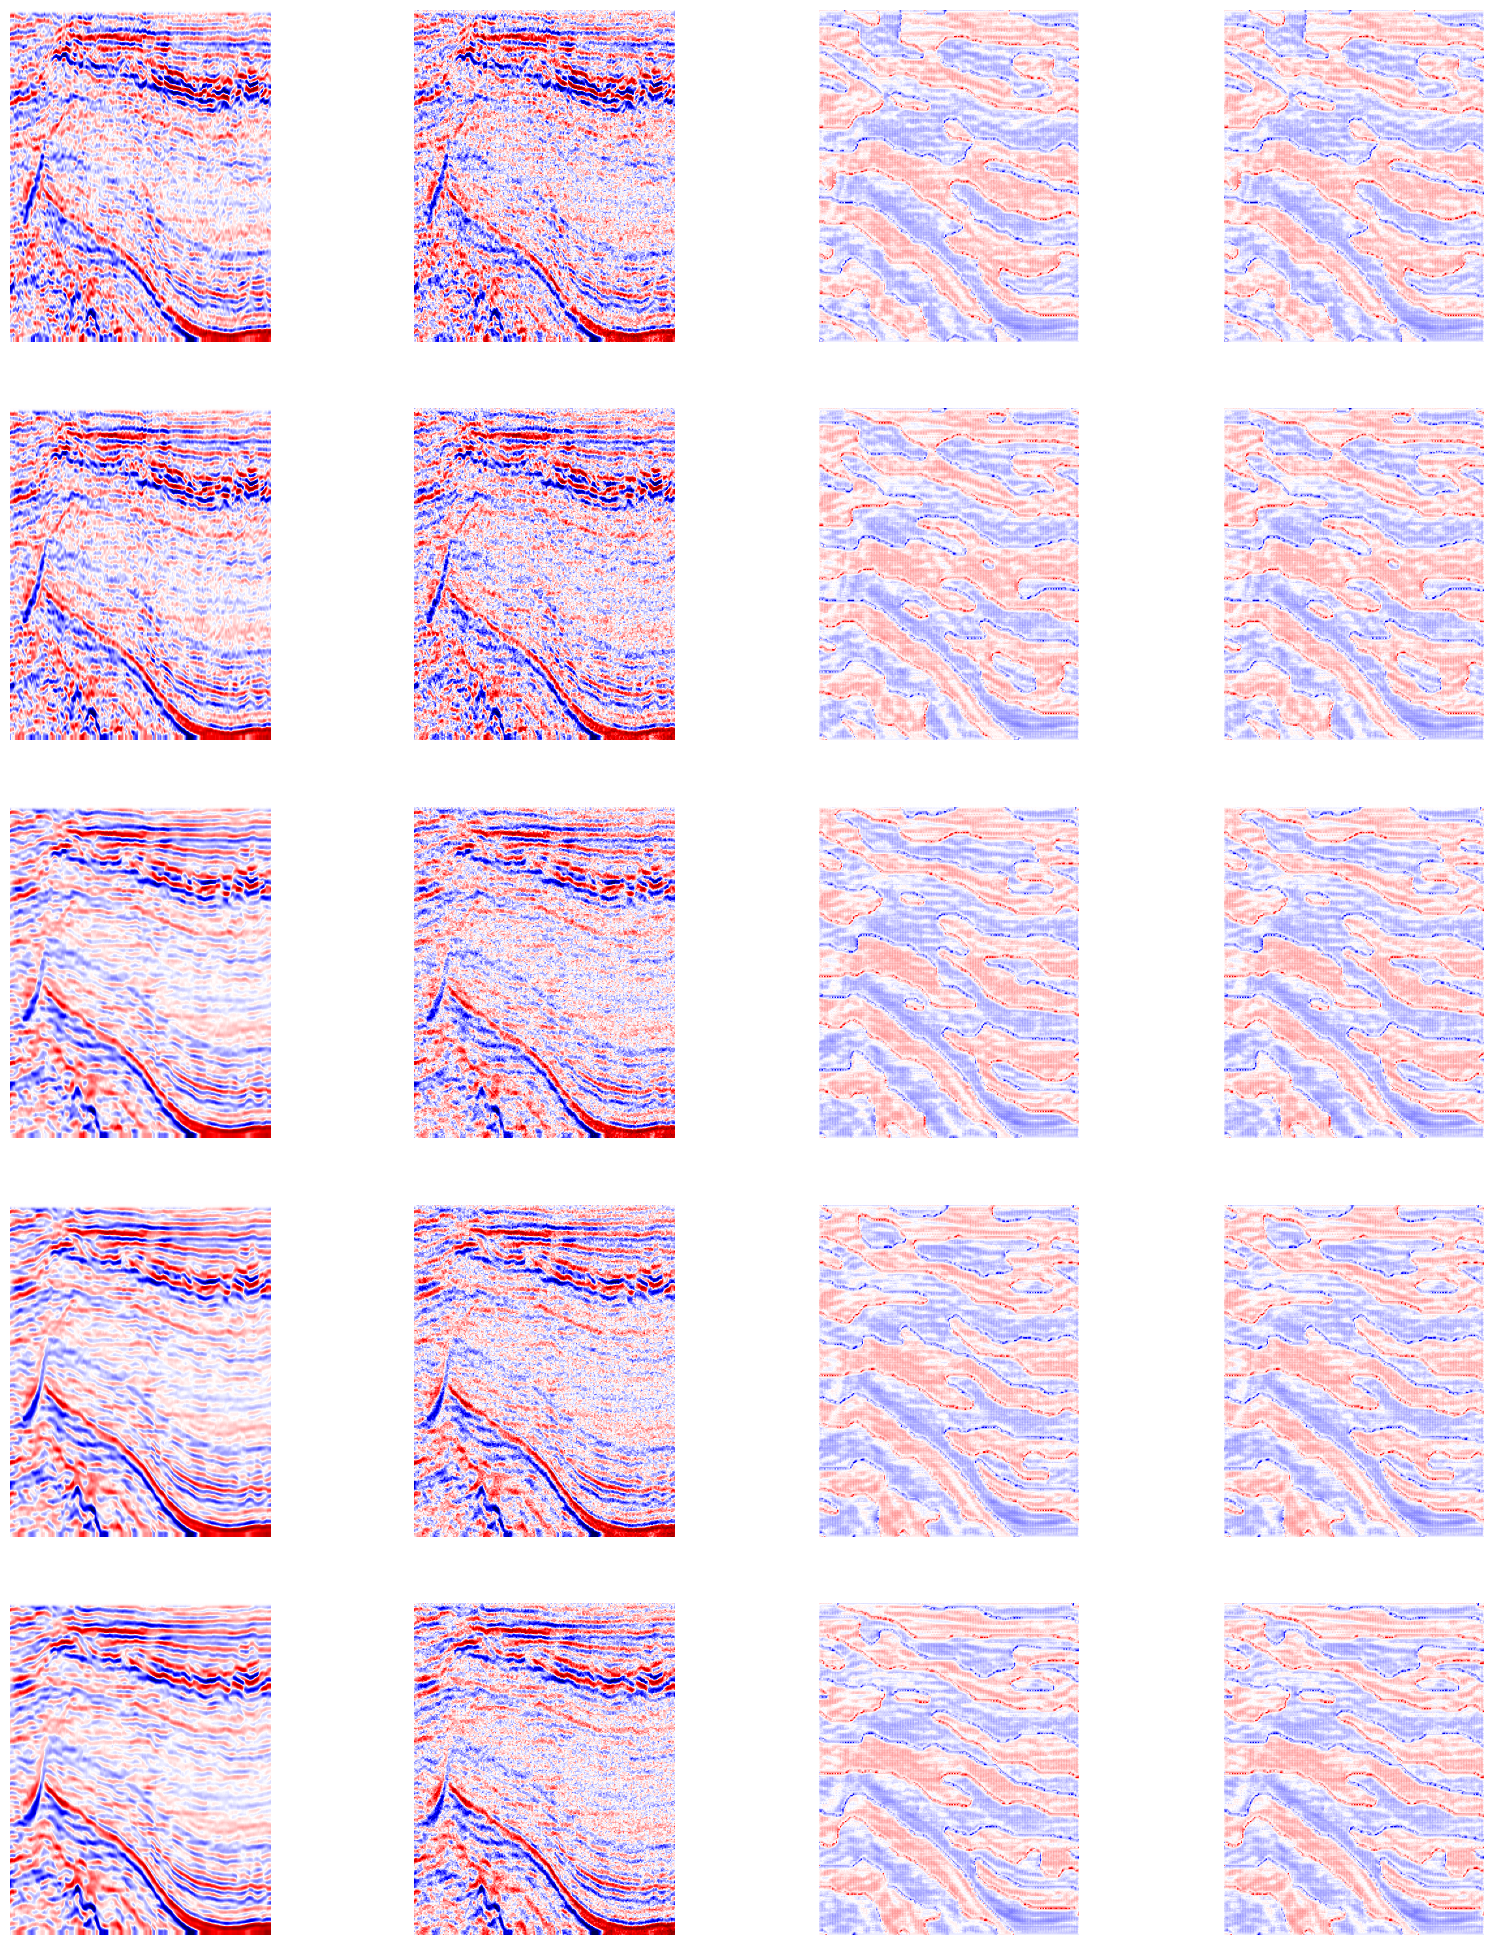

In [50]:
fig, ax = plt.subplots(ncols=4, nrows = 5, figsize=(5*4, 5 * 5))

for i in range(5) : 
    clean_inline = test_data[i]
    noisy_inline = noisy_test_data[i]
    denoised_inline = denoised[i]
    denoised_inline_gan = denoised_gan[i]

    kwargs = dict(cmap = 'seismic',
                   vmin = -1, vmax = 1
                   )

    ax[i,0].imshow(clean_inline.T, **kwargs)
    ax[i,0].axis('off')
    ax[i,1].imshow(noisy_inline.T, **kwargs)
    ax[i,1].axis('off')
    ax[i,2].imshow(denoised_inline, **kwargs)
    ax[i,2].axis('off')
    ax[i,3].imshow(denoised_inline_gan, **kwargs)
    ax[i,3].axis('off')
    # ax[i,3].imshow(diff.T, **kwargs)
    # ax[i,3].axis('off')
plt.show()